In [1]:
import os
import re
import sys

import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics as skmetrics
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.font_manager import fontManager
from IPython.display import display
from ipywidgets import interact, FloatSlider
from umap import UMAP
from sklearn.decomposition import PCA
import ipynbname
from endaaman.ml import fix_global_seed

project_root = os.path.abspath(os.path.join(os.path.dirname(ipynbname.path()), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
os.chdir(project_root)
print('now working', project_root)

DPI = 300

sns.set_theme(style="ticks", palette="tab10")
# sns.set_theme(style="white")
# plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Verdana'
plt.rcParams['font.size'] = 10  
plt.rcParams['axes.labelsize'] = 12  
plt.rcParams['axes.titlesize'] = 14  
plt.rcParams['xtick.labelsize'] = 10  
plt.rcParams['ytick.labelsize'] = 10 
plt.rcParams['figure.dpi'] = DPI

os.makedirs('out/figs', exist_ok=True)

fix_global_seed()

# print(f"デフォルトのフォント: {plt.rcParams['font.sans-serif']}")
# print(', '.join(sorted(list(set([font.name for font in fontManager.ttflist if not font.name.startswith('Noto')])))))

now working /home/ken/src/github.com/endaaman/bt


In [12]:
def cluster(path, 
            mode = 'label',
           ):
    df = pd.read_excel(path)
    unique_codes = list(df['Diagnosis'].unique())

    if 'multi':
        fig = plt.figure(figsize=(12, 6))
        ax_label = fig.add_subplot(1, 2, 1)
        ax_origin = fig.add_subplot(1, 2, 2)
    else:
        fig = plt.figure(figsize=(8, 6))
        ax_label = fig.add_subplot(1, 1, 1)
        ax_origin = ax_label

    if mode in ['label', 'multi']:
        g = sns.scatterplot(
            data=df,
            x='UMAP1', y='UMAP2',
            hue='Diagnosis',
            style='Dataset',  
            markers={'Local': 'o', 'EBRAINS': 'X'}, 
            hue_order=unique_codes,
            palette='tab10',
            s=12,
            # alpha=0.7,
            ax=ax_label,
        )
        ax_label.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if mode in ['origin', 'multi']:
        origin_count = len(df['origin'].unique())
        pallete = ['gray'] + list(sns.color_palette('husl'))[:origin_count-1]
        g = sns.scatterplot(
            data=df,
            x='UMAP1', y='UMAP2',
            hue='origin',
            style='Dataset',  
            markers={'Local': 'o', 'EBRAINS': 'X'}, 
            # hue_order=unique_codes,
            palette=pallete,
            s=12,
            # alpha=0.7,
            ax=ax_origin,
        )
        ax_origin.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # if mode == 'multi':
    #     plt.subplots_adjust(wspace=0.5)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_5075/653812399.py:33: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  g = sns.scatterplot(


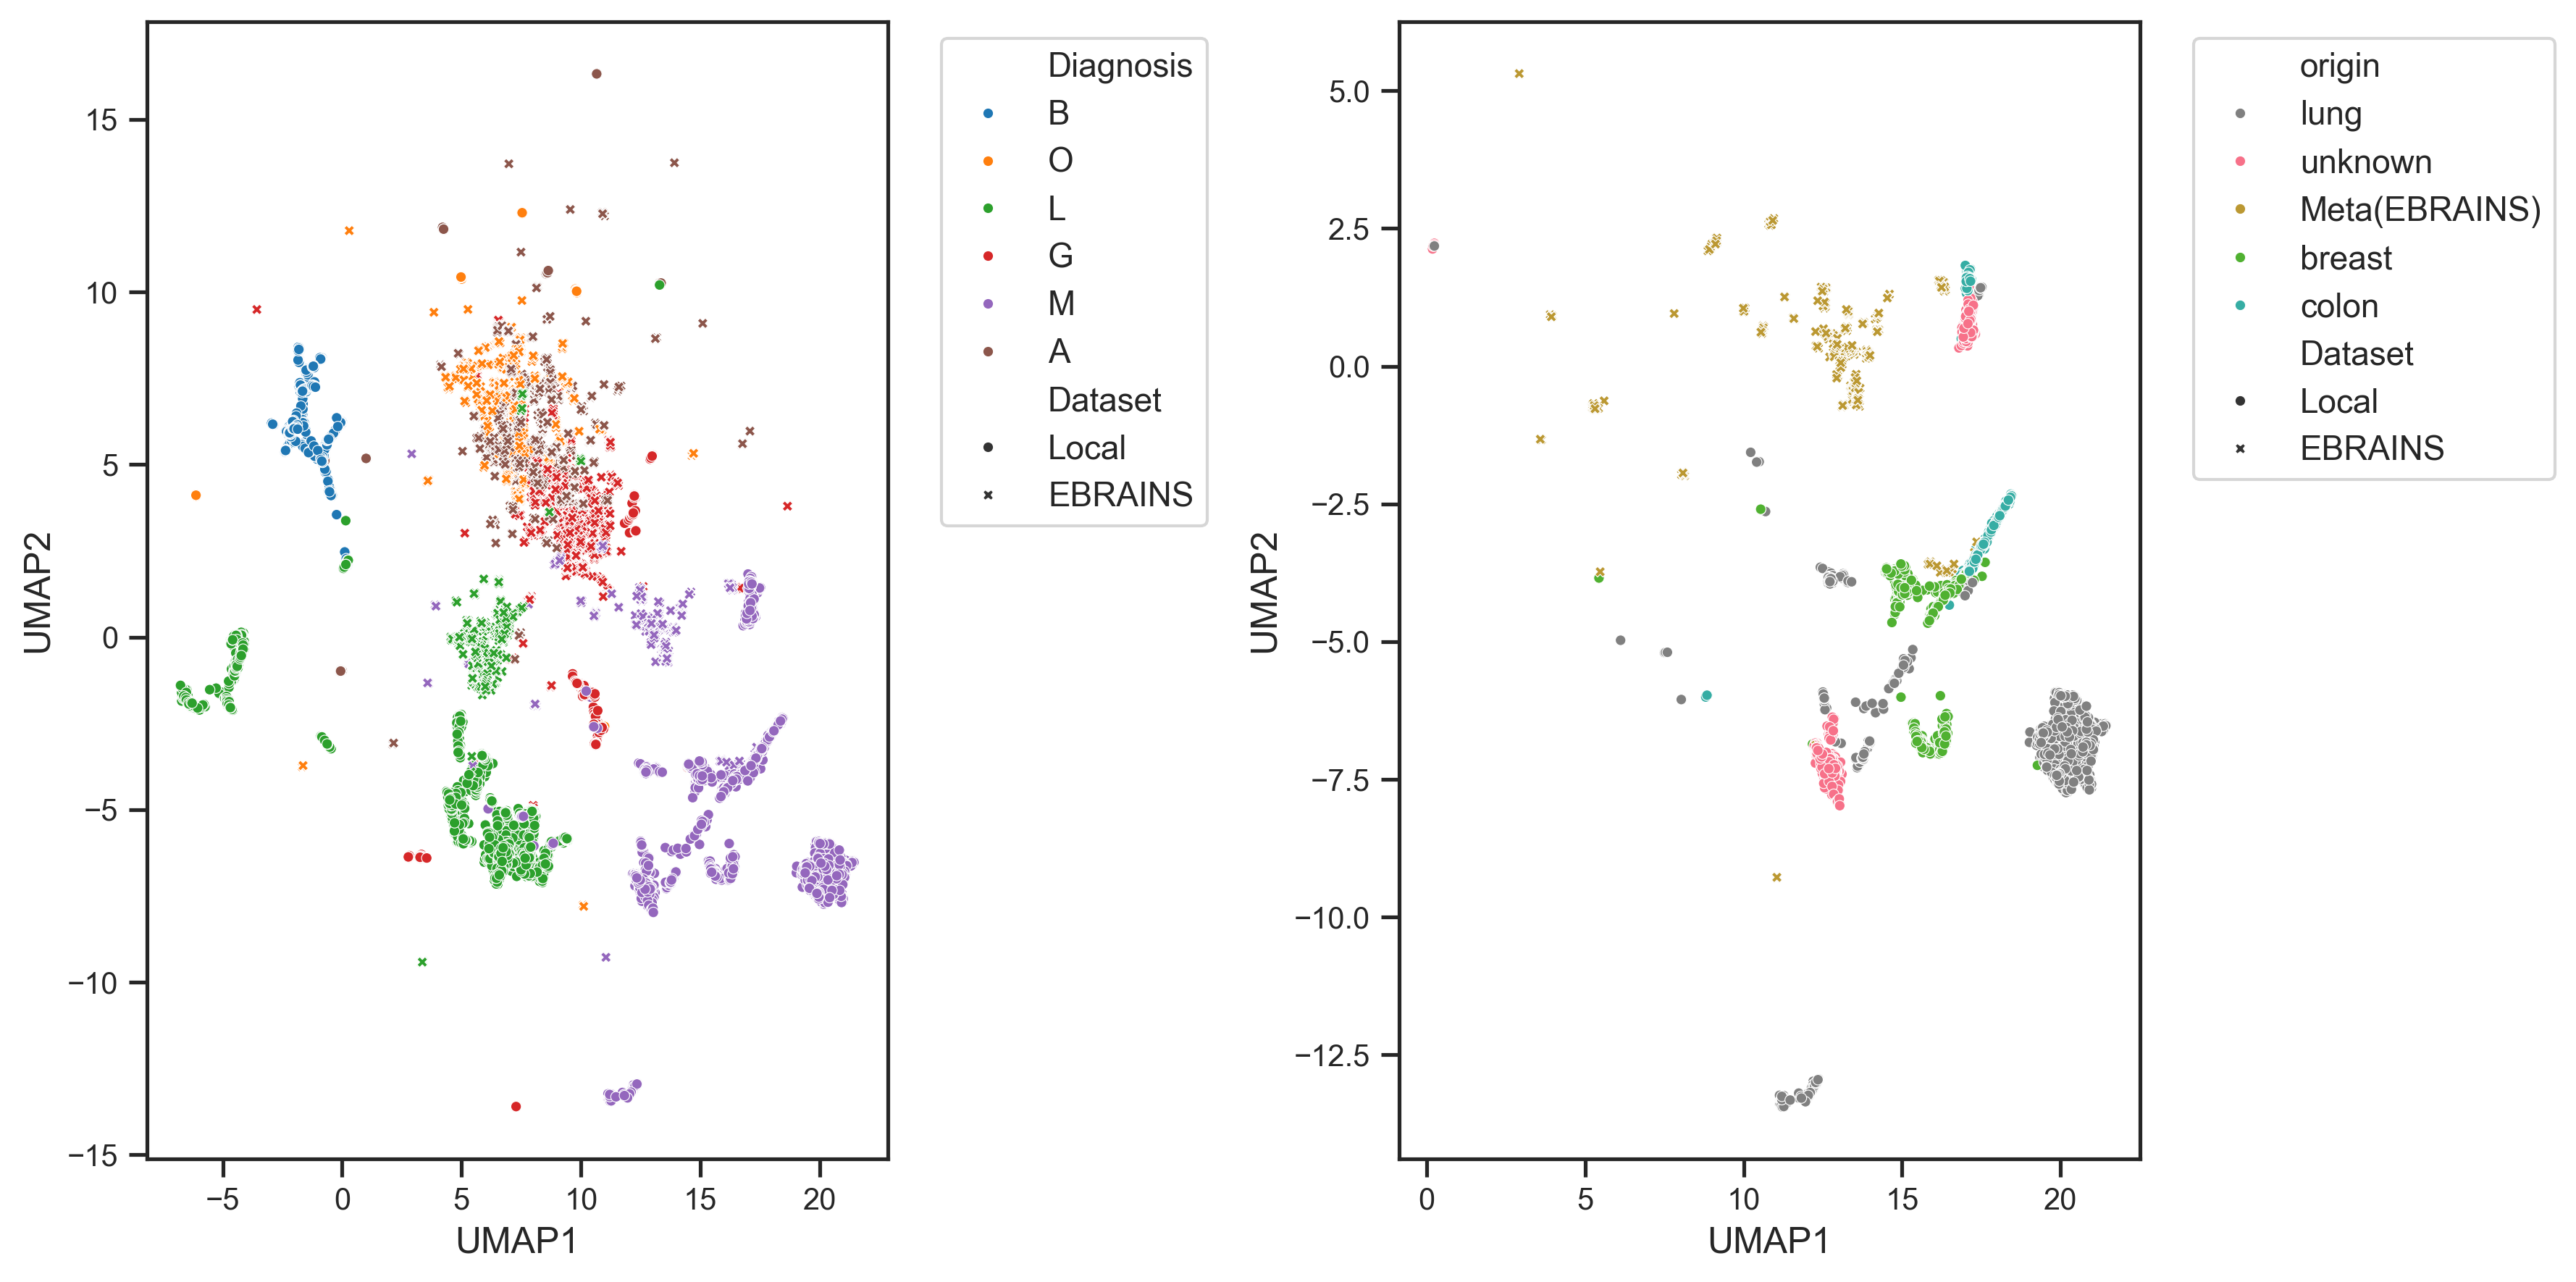

In [13]:
# UNI(LP)
cluster(
    'out/compare/LMGAOB/fold5_0/frozen_uni_500/integrated_umap_embeddings.xlsx',
    mode = 'multi',
)

In [2]:
df_meta_origins = pd.read_excel('data/meta_origin.xlsx')
# print(df_meta_origins)

# cols = ['name', 'diag_org', 'pred', 'feature']
# df = pd.DataFrame(torch.load('out/compare/LMGAOB/fold5_0/frozen_uni_100/features_test.pt'))[cols]
# df['Dataset'] = 'Local'
# df = pd.merge(df, df_meta_origins, on='name', how='left')
# df.fillna(0, inplace=True)
# df

In [3]:
def cluster(cv_pt=None, 
            ebrains_pt=None,
            cv_count_per_case = 20,
            ebrains_count_per_case = -1,
            n_neighbors = 60,
            min_dist = 0.1,
            projection = 'umap',
            mode = 'label',
            show = True,
           ):
    if cv_pt is None and ebrains_pt is None:
        raise RuntimeError('At least cv or ebrains must be provided.')

    if ebrains_count_per_case < 0:
        ebrains_count_per_case = cv_count_per_case // 2

    cols = ['name', 'diag_org', 'pred', 'feature']
    
    df = pd.DataFrame([])
    if cv_pt:
        df = pd.DataFrame(torch.load(cv_pt))[cols]
        df['Dataset'] = 'Local'
        df = pd.merge(df, df_meta_origins, on='name', how='left')
        df.fillna('', inplace=True)
        print('cv', len(df))

    if ebrains_pt:
        df_ebrains = pd.DataFrame(torch.load(ebrains_pt))[cols]
        df_ebrains['Dataset'] = 'EBRAINS'
        df_ebrains['origin'] = ''
        df_ebrains.loc[df_ebrains['diag_org'] == 'M', 'origin'] = 'Meta(EBRAINS)'
        print('ebrains', len(df_ebrains))
        df = pd.concat([df_ebrains, df])

    unique_codes = df['diag_org'].unique()
    
    rowss = []
    rng = np.random.default_rng(42)
    for name, _rows in df.groupby('name'):
        count = cv_count_per_case if _rows.iloc[0]['Dataset'] == 'Local' else ebrains_count_per_case
        # rows = df.loc[np.random.choice(_rows.index, count)]
        # rows = df.iloc[:count]
        # ii = rng.choice(_rows.index, count)
        ii = _rows.index[:count]
        rows = df.loc[ii]
        rowss.append(rows)
    df = pd.concat(rowss)
    # print(df)

    features = np.stack(df['feature'])
    print('Start projection')

    if projection.lower() == 'umap':
        reducer = UMAP(
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            n_components=2,
            n_jobs=1,
            random_state=42,
        )
        embedding = reducer.fit_transform(features)
    elif projection.lower() == 'pca':
        reducer = PCA(
            n_components=2,
            random_state=42,
        )
        embedding = reducer.fit_transform(features)
        print(f"Explained variance ratio: {reducer.explained_variance_ratio_}")
        print(f"Cumulative explained variance ratio: {np.cumsum(reducer.explained_variance_ratio_)}")        
    else:
        raise ValueError(f"Unknown projection method: {projection_method}. Use 'umap' or 'pca'.")

    print('Done projection')
    
    df['UMAP1'] = embedding[:, 0]
    df['UMAP2'] = embedding[:, 1]
    df = df.rename(columns={'diag_org': 'Diagnosis'})

    if 'multi':
        fig = plt.figure(figsize=(12, 6))
        ax_label = fig.add_subplot(1, 2, 1)
        ax_origin = fig.add_subplot(1, 2, 2)
    else:
        fig = plt.figure(figsize=(8, 6))
        ax_label = fig.add_subplot(1, 1, 1)
        ax_origin = ax_label

    if mode in ['label', 'multi']:
        g = sns.scatterplot(
            data=df,
            x='UMAP1', y='UMAP2',
            hue='Diagnosis',
            style='Dataset',  
            markers={'Local': 'o', 'EBRAINS': 'X'}, 
            hue_order=unique_codes,
            palette='tab10',
            s=12,
            # alpha=0.7,
            ax=ax_label,
        )
        ax_label.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if mode in ['origin', 'multi']:
        origin_count = len(df['origin'].unique())
        pallete = ['gray'] + list(sns.color_palette('husl'))[:origin_count-1]
        g = sns.scatterplot(
            data=df,
            x='UMAP1', y='UMAP2',
            hue='origin',
            style='Dataset',  
            markers={'Local': 'o', 'EBRAINS': 'X'}, 
            # hue_order=unique_codes,
            palette=pallete,
            s=12,
            # alpha=0.7,
            ax=ax_origin,
        )
        ax_origin.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # if mode == 'multi':
    #     plt.subplots_adjust(wspace=0.5)
    plt.tight_layout()
    plt.show()

cv 60349
ebrains 8612
Start projection
Done projection


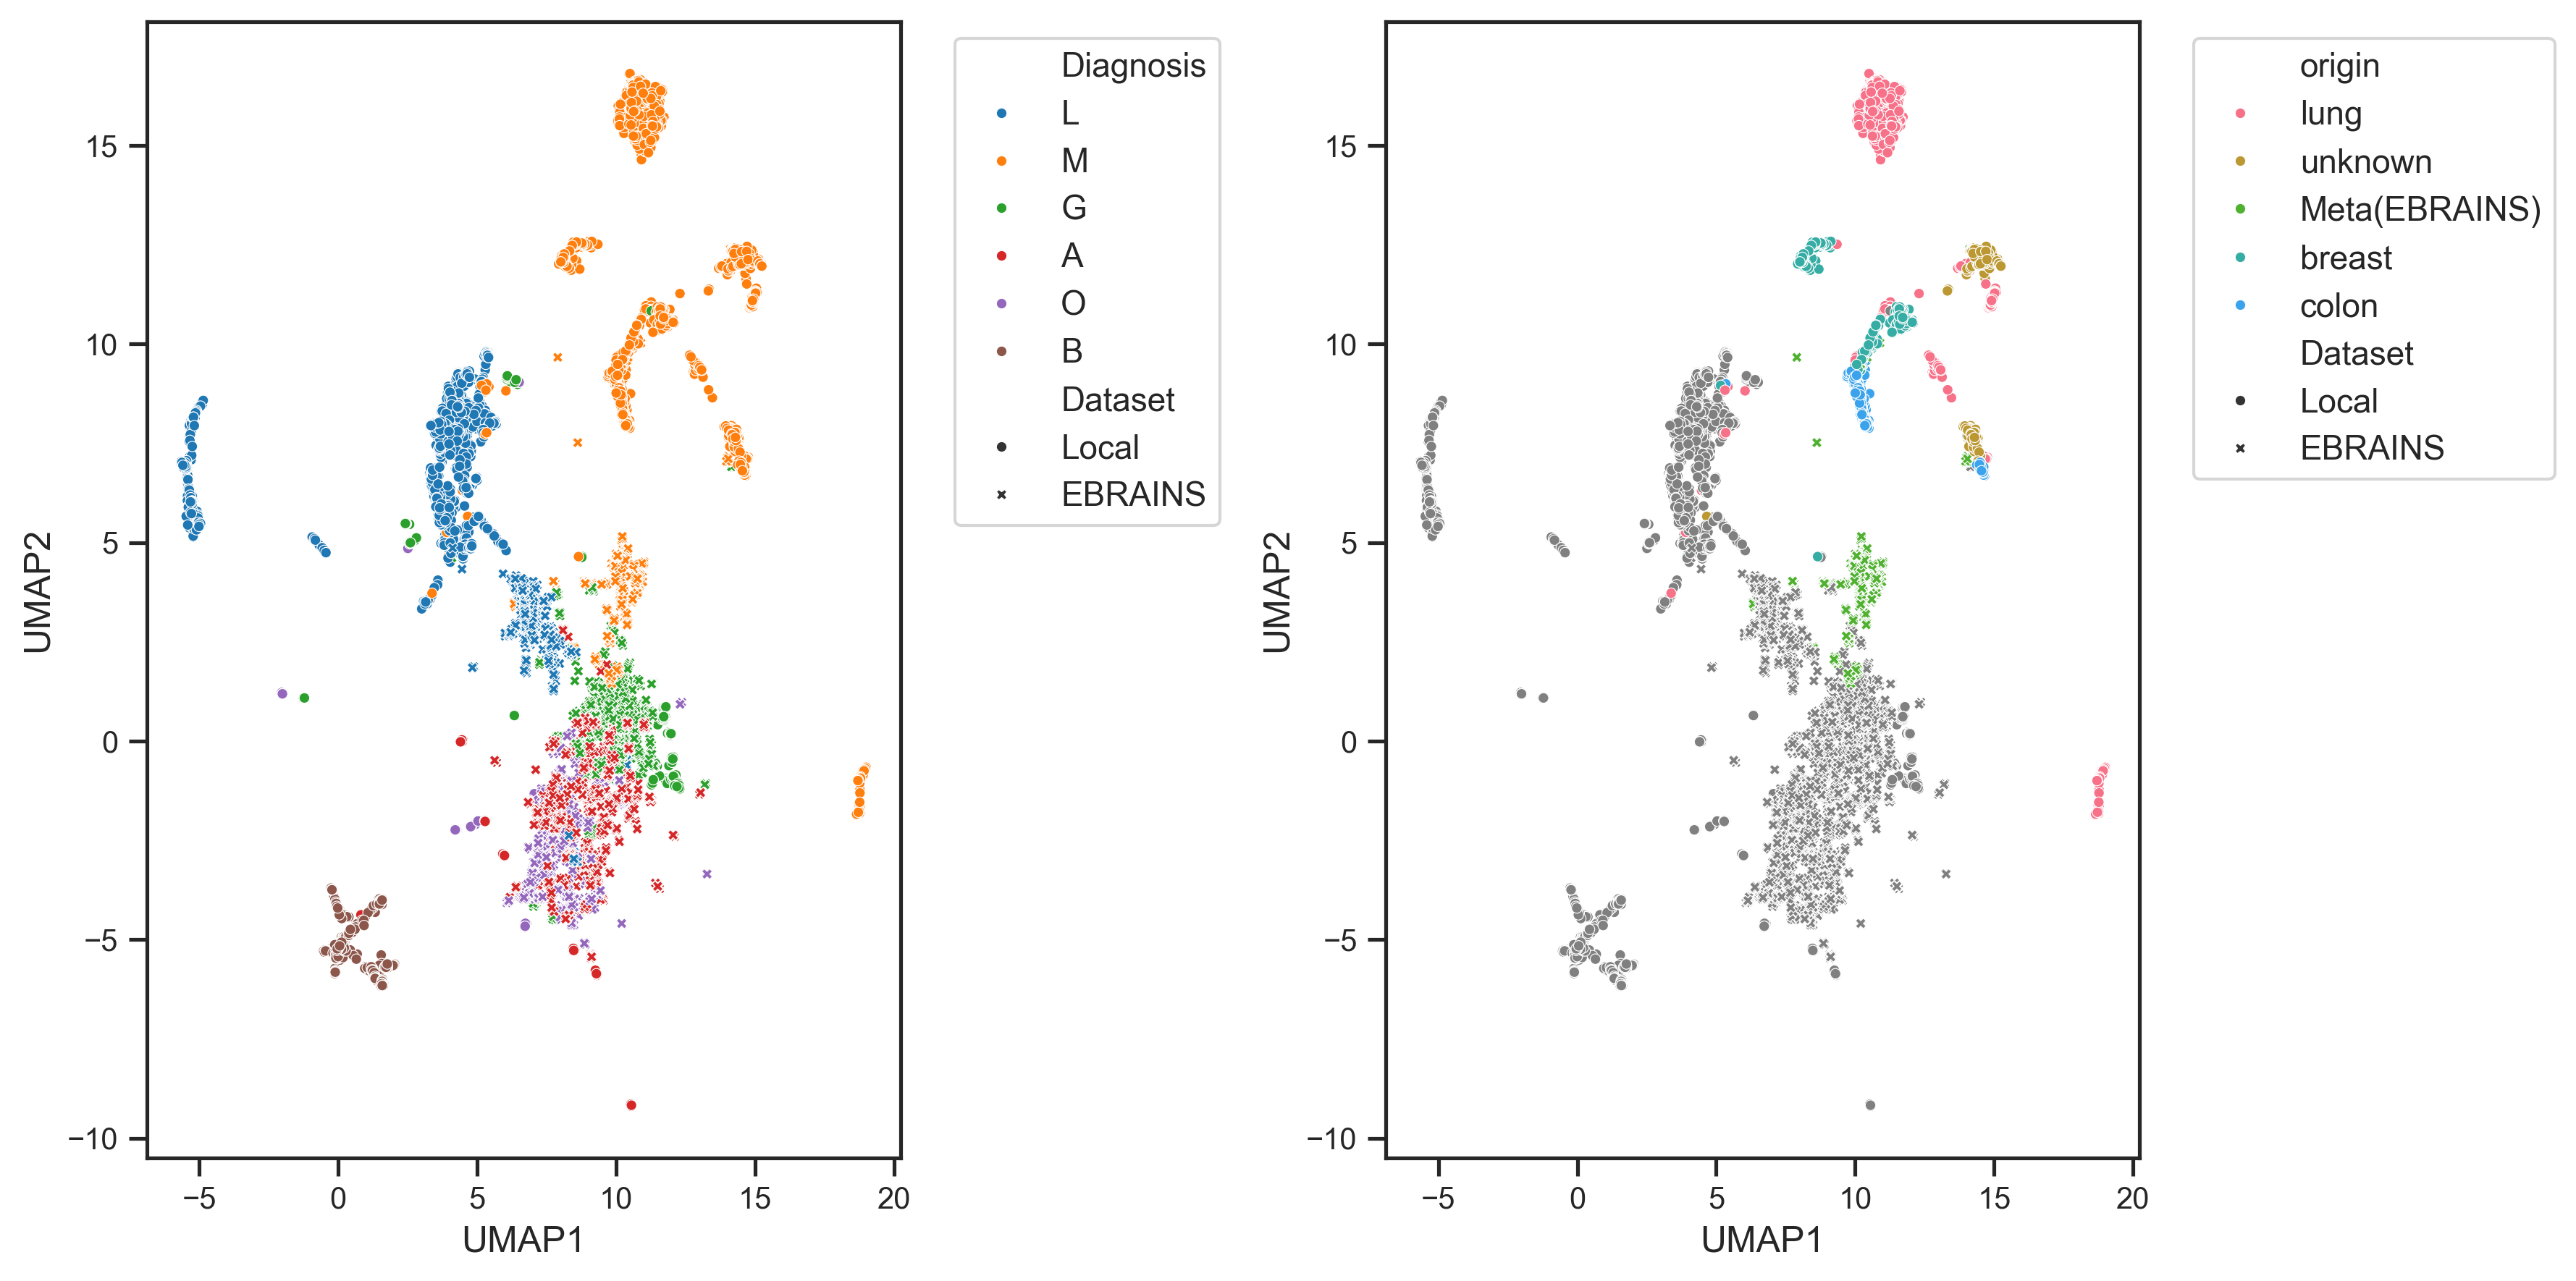

cv 60349
ebrains 8612
Start projection
Done projection


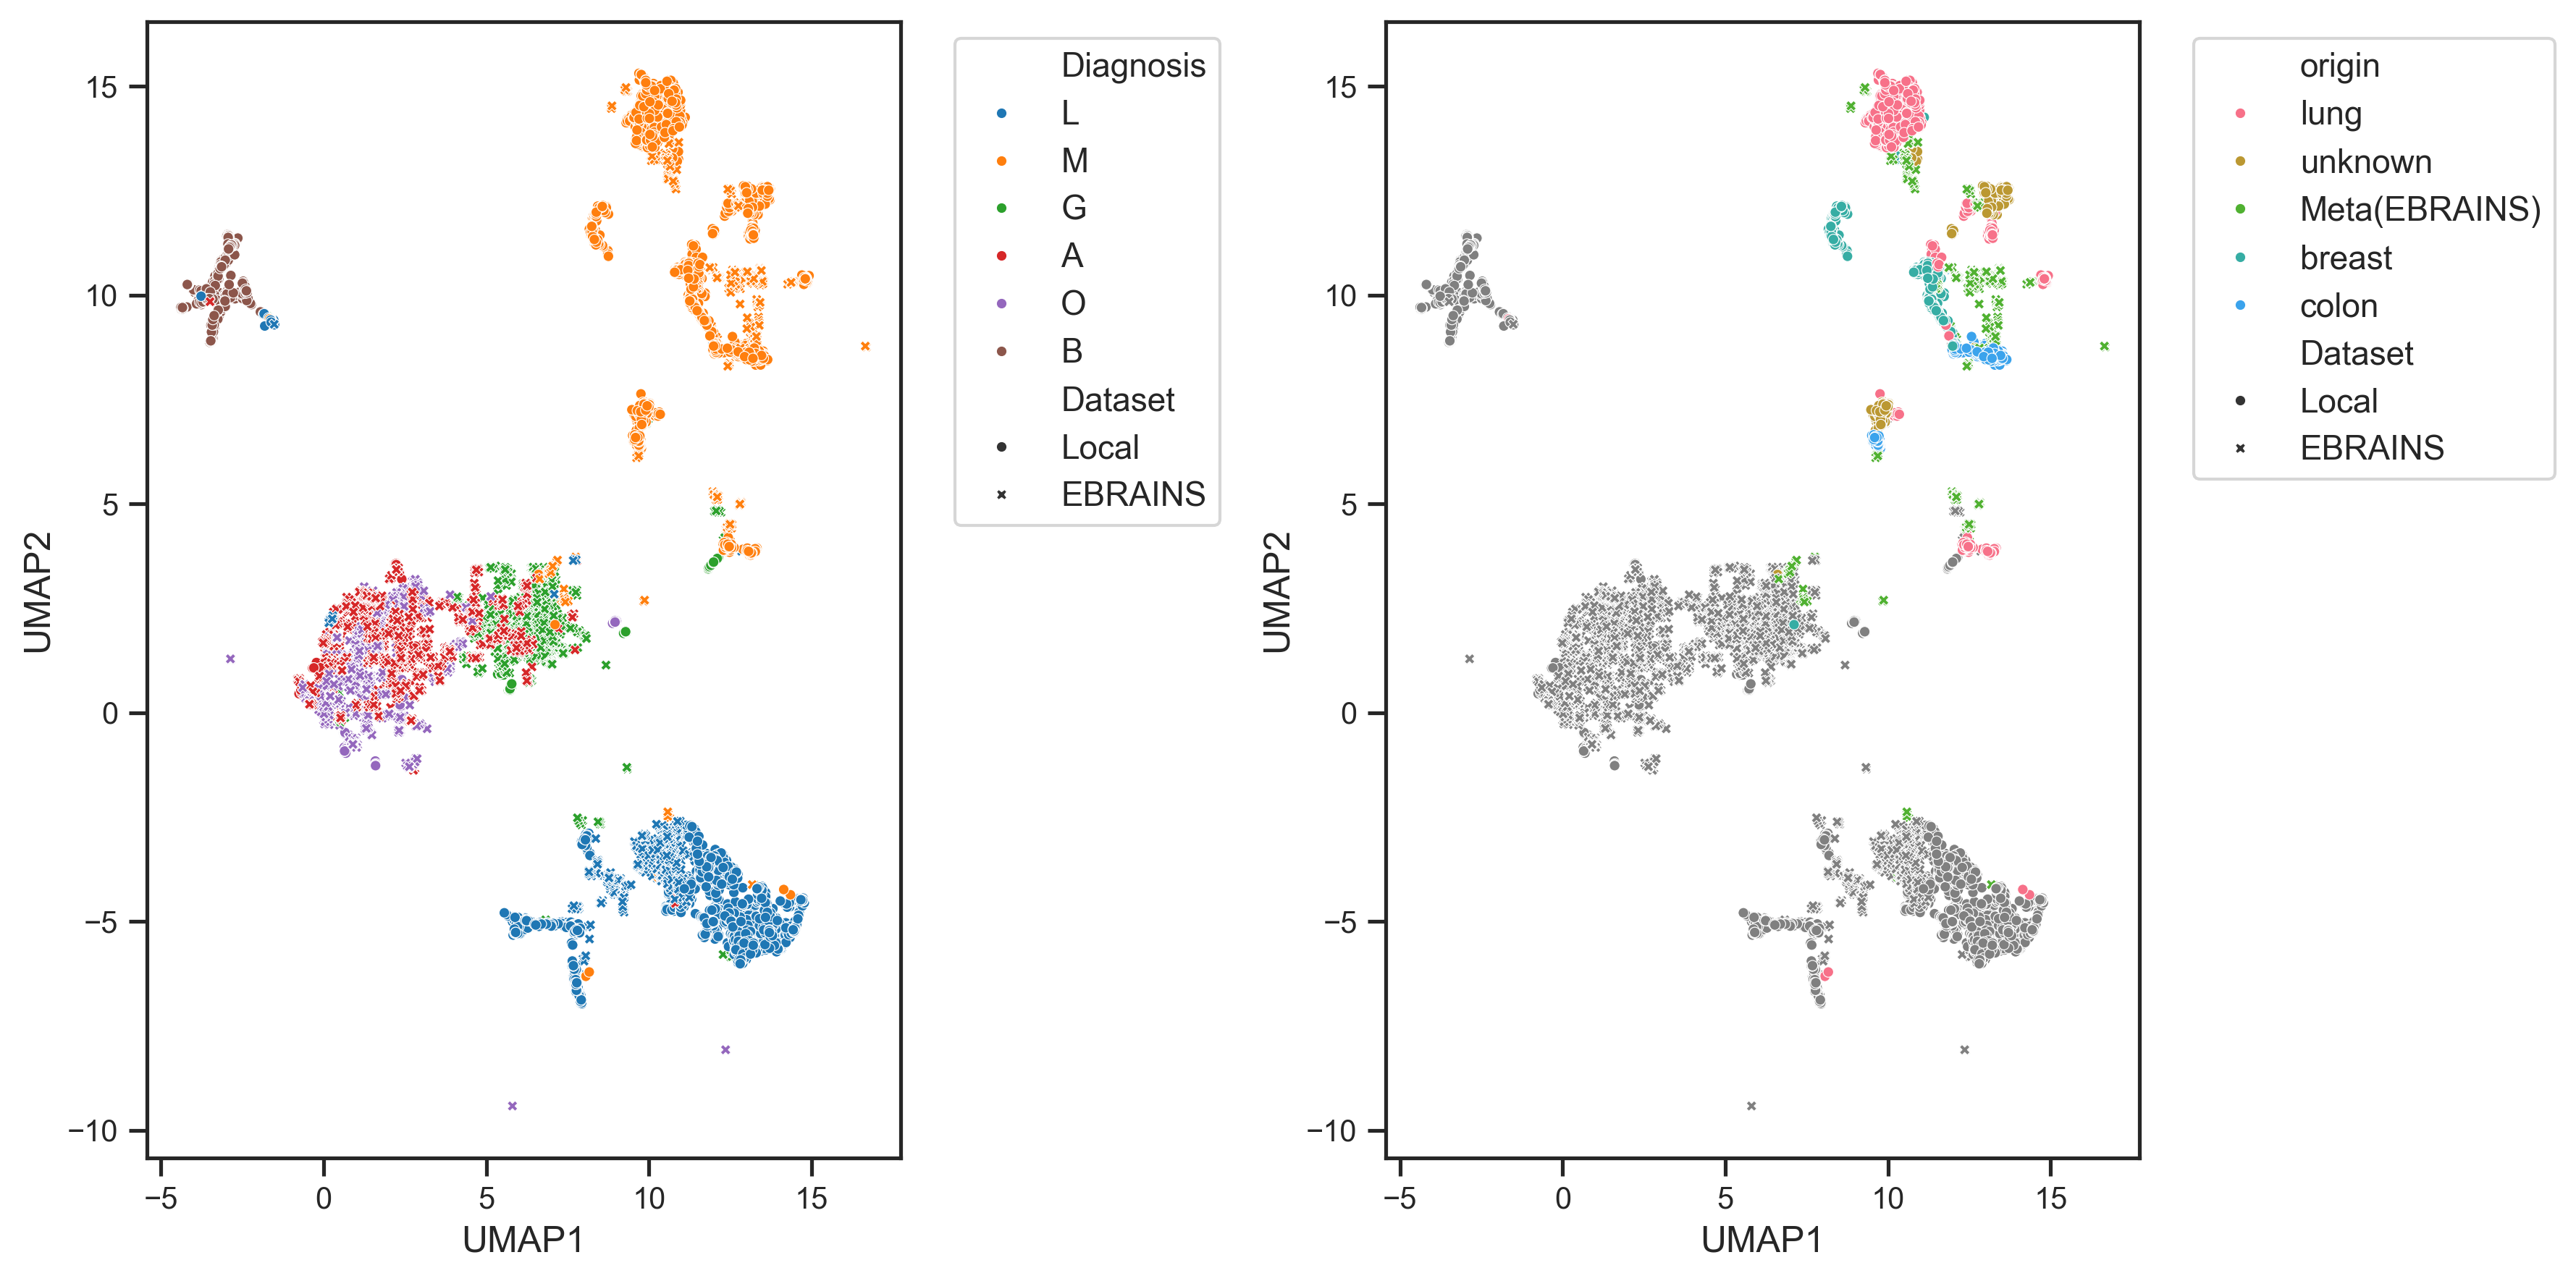

In [4]:
# UNI(LP)
cluster(
    'out/compare/LMGAOB/fold5_0/frozen_uni_500/features_test.pt',
    'out/compare/LMGAOB/fold5_0/frozen_uni_500/features_ebrains.pt',
    mode = 'multi',
)
# UNI(FT)
cluster(
    'out/compare/LMGAOB/fold5_0/unfrozen_uni_500/features_test.pt',
    'out/compare/LMGAOB/fold5_0/unfrozen_uni_500/features_ebrains.pt',
    mode = 'multi',
)

cv 60349
ebrains 8612
Start projection
Done projection


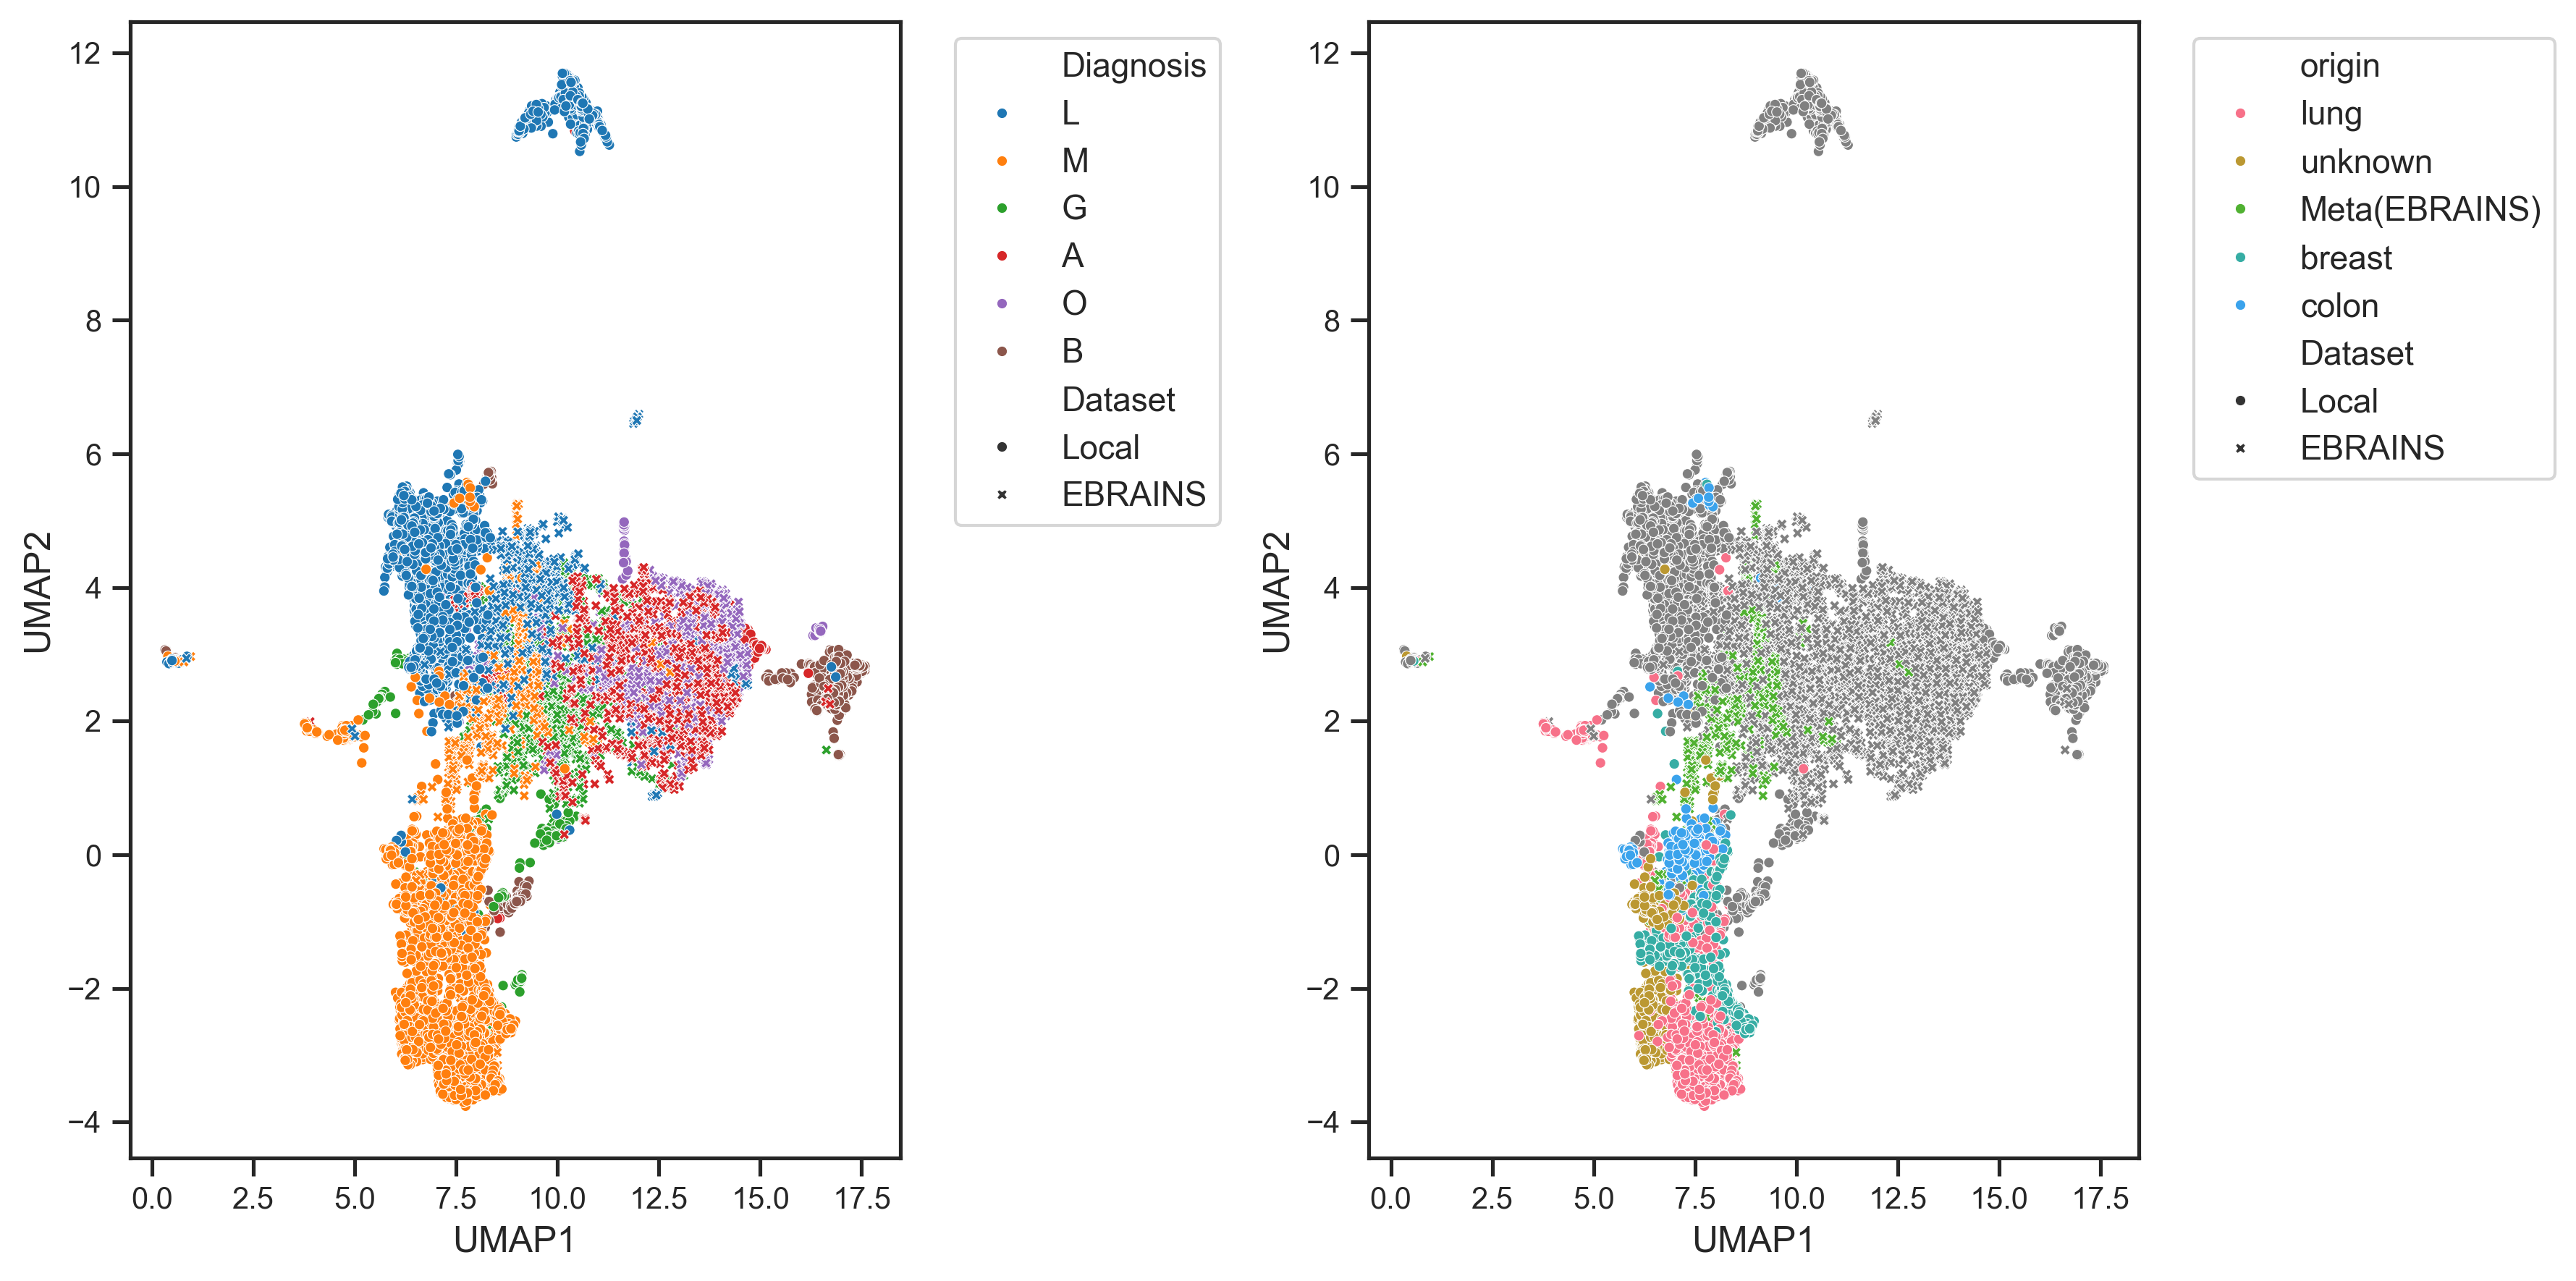

cv 60349
ebrains 8612
Start projection
Done projection


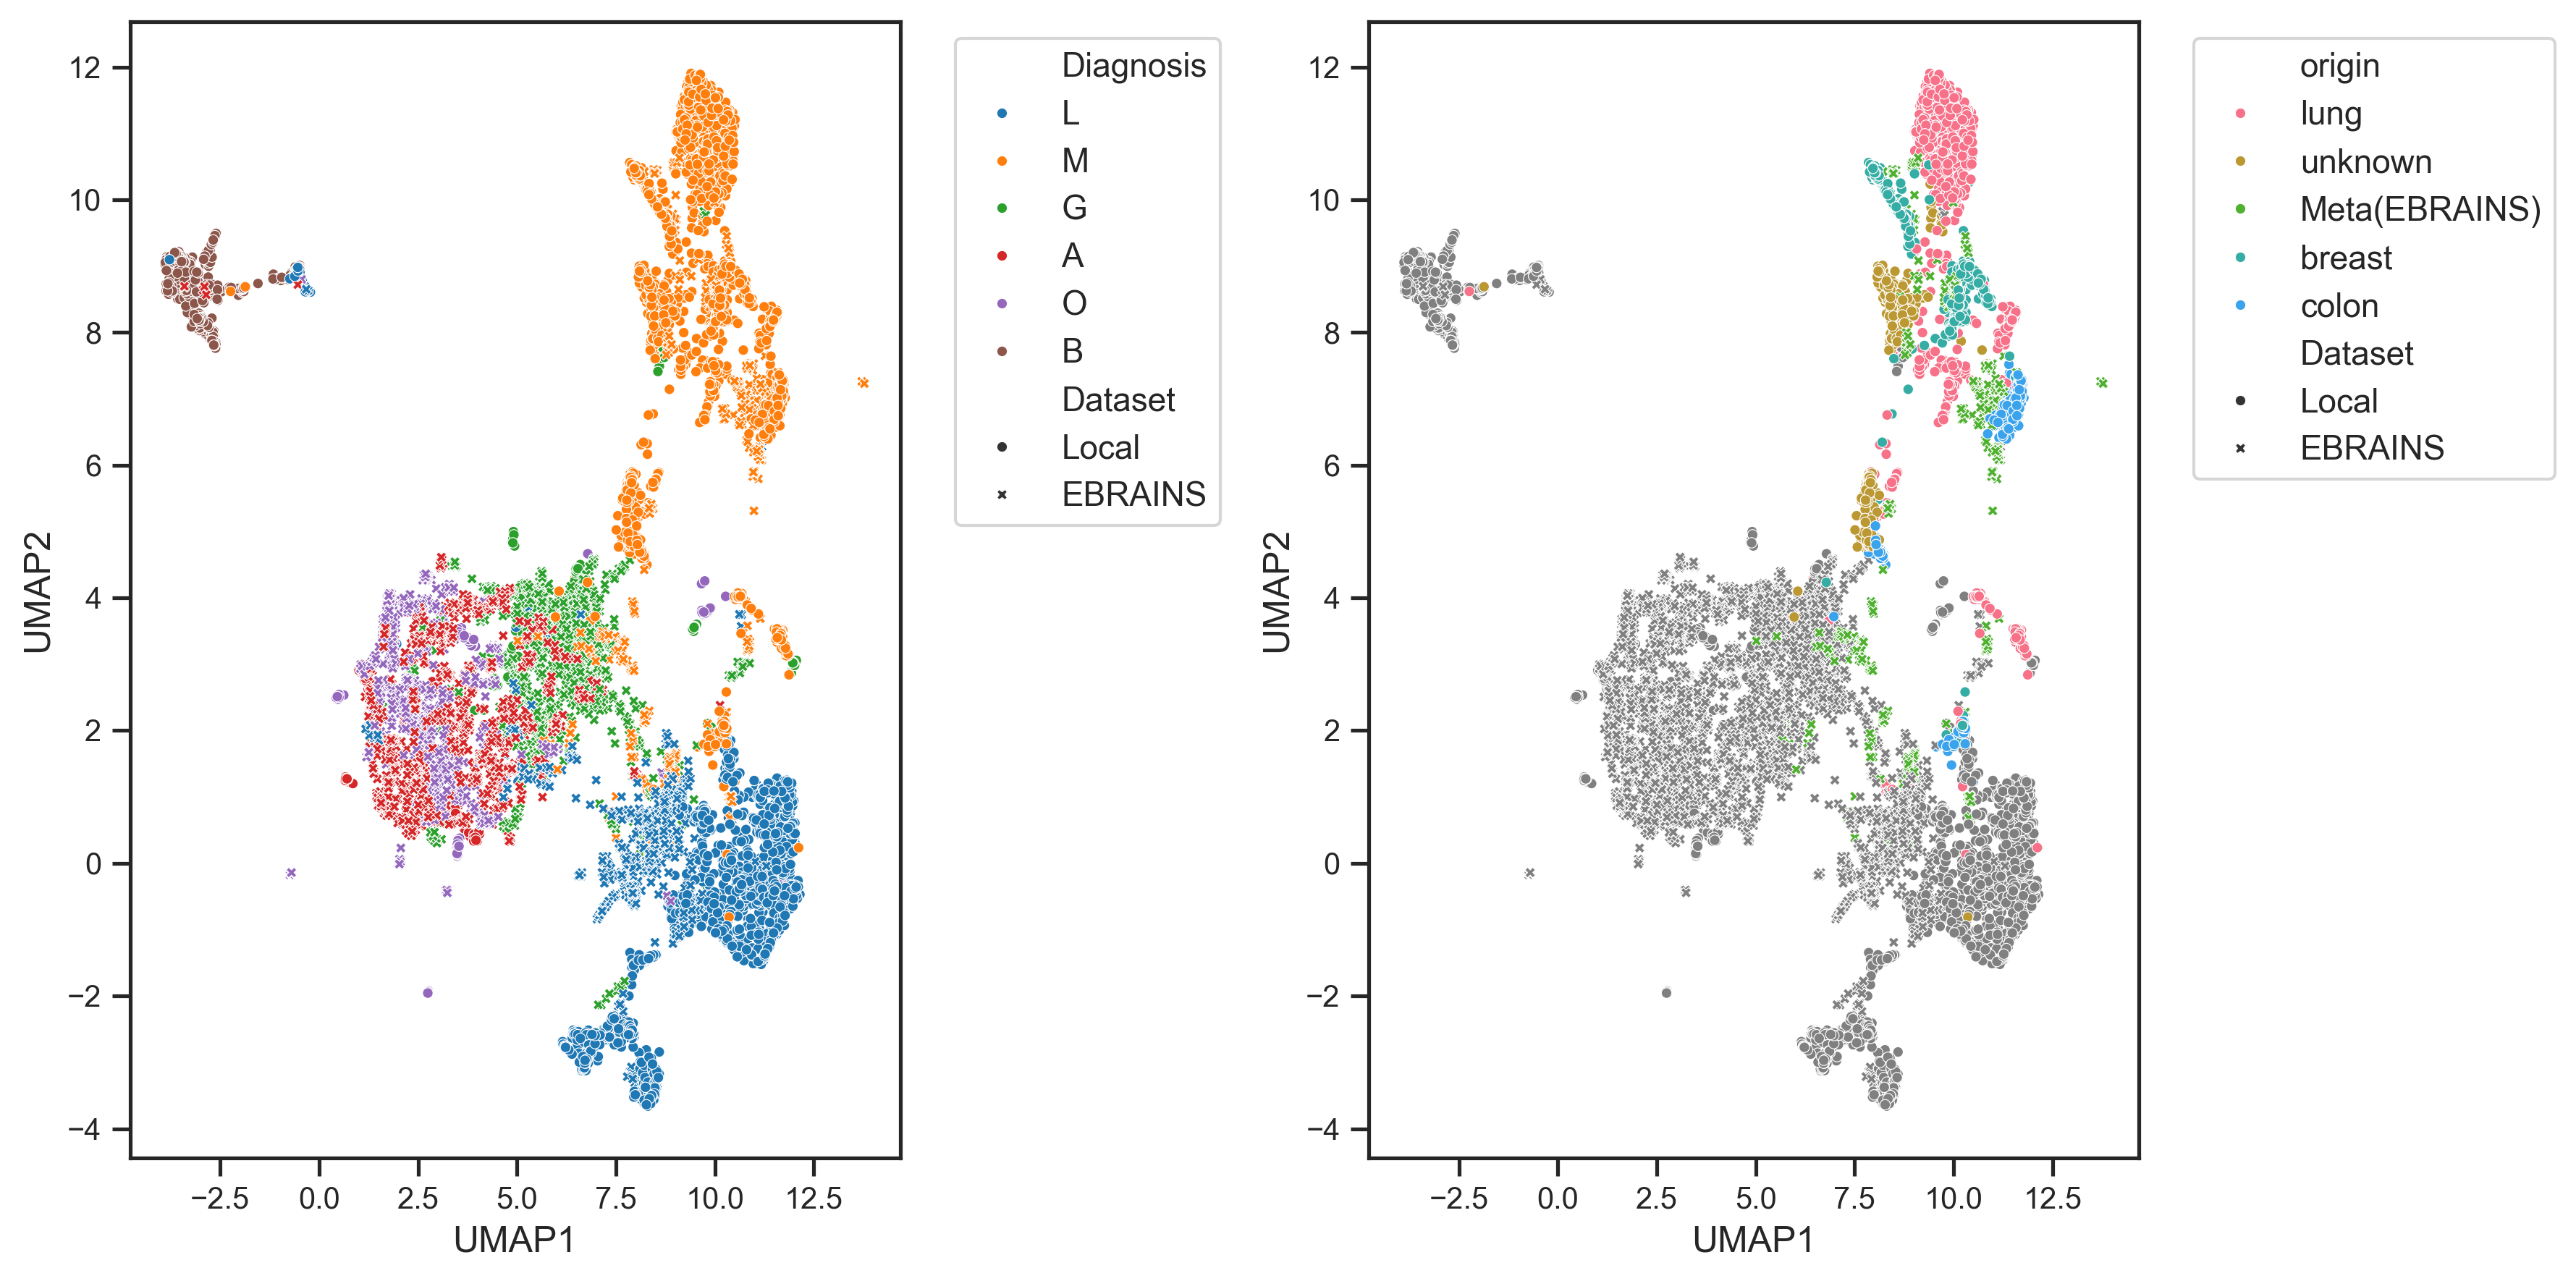

cv 60349
ebrains 8612
Start projection
Done projection


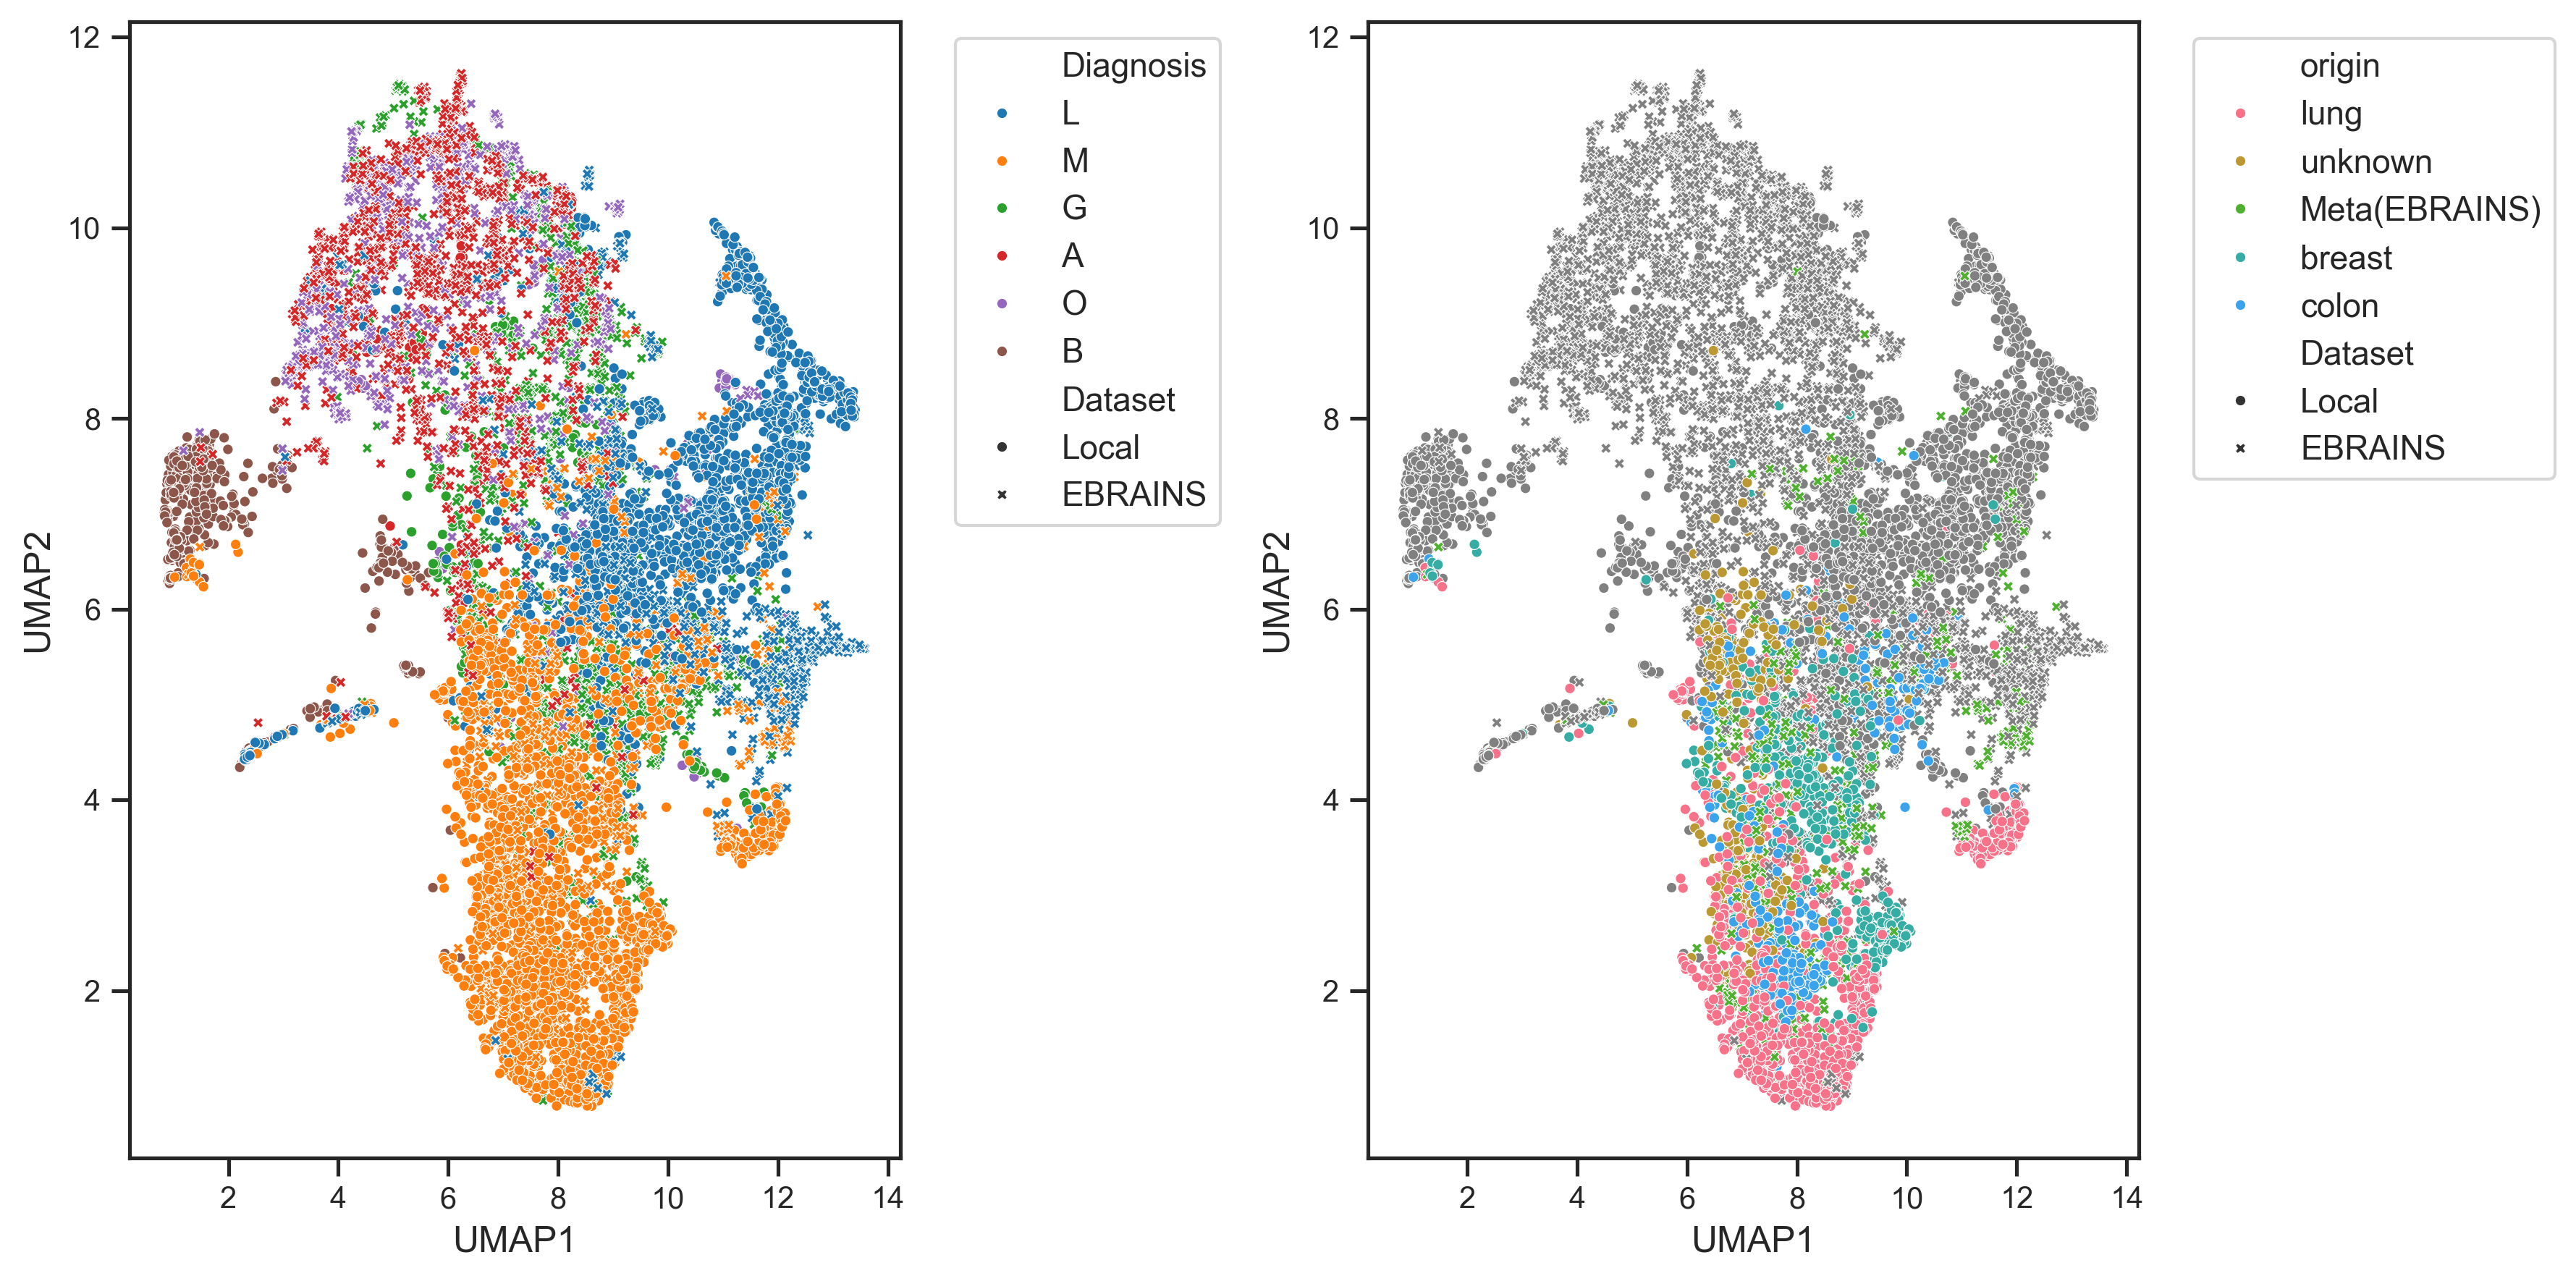

In [5]:
# VIT-L(LP)
cluster(
    'out/compare/LMGAOB/fold5_0/frozen_baseline-vit_500/features_test.pt',
    'out/compare/LMGAOB/fold5_0/frozen_baseline-vit_500/features_ebrains.pt',
    mode = 'multi',
)
# VIT-L(FT)
cluster(
    'out/compare/LMGAOB/fold5_0/unfrozen_baseline-vit_500/features_test.pt',
    'out/compare/LMGAOB/fold5_0/unfrozen_baseline-vit_500/features_ebrains.pt',
    mode = 'multi',
)
# VIT-L(BS)
cluster(
    'out/compare/LMGAOB/fold5_0/unfrozen_random-vit_100/features_test.pt',
    'out/compare/LMGAOB/fold5_0/unfrozen_random-vit_100/features_ebrains.pt',
    mode = 'multi',
)